<a href="https://colab.research.google.com/github/zfurman56/boolean_circuits/blob/main/Boolean_circuits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [363]:
import numpy as np
import itertools, copy
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import plotly.express as px

In [170]:
class FunctionGraphEvaluator:
    def __init__(self, graph):
        """
        Initialize the FunctionGraphEvaluator with a networkx directed acyclic graph.

        Args:
        graph (networkx.MultiDiGraph): A directed acyclic graph where nodes represent function instances
                                    and edge attributes contain input-output connections.
        """
        self.graph = graph

    def evaluate(self, coordinates):
        """
        Evaluates the functions using the hierarchical structure defined by the graph.

        Args:
        coordinates (list or np.ndarray): A list or array of coordinates to be processed.

        Returns:
        np.ndarray: An array of merged output values.
        """
        # Ensure coordinates are in a NumPy array
        coordinates = np.atleast_2d(coordinates)

        # Initialize a dictionary to store the output values
        output_values = {}

        # Calculate the output values
        for node in nx.topological_sort(self.graph):
            input_data = []

            for p, _ in self.graph.in_edges(node):
                input_data.append(output_values[p])

            if type(node) == str and node.startswith('input'):
                assert(len(input_data) == 0)
                index = int(node.split('_')[1])
                output_values[node] = coordinates[:, index].reshape(-1, 1)

            elif type(node) == str and node.startswith('output'):
                assert(len(input_data) == 1)
                output_values[node] = input_data[0]

            else:
                inputs = np.hstack(input_data)
                function = self.graph.nodes[node]['function']
                output_values[node] = function(inputs).reshape(-1, 1)

        # Collect output values
        sorted_output_nodes = sorted([n for n in output_values if type(n) == str and n.startswith('output')],
                                    key=lambda x: int(x.split('_')[1]))
        result = np.hstack([output_values[node] for node in sorted_output_nodes])

        return result

In [171]:
# Define polynomial functions for each node
def poly1(x):
    # f(x) = x^2 + 2x + 3
    return x**2 + 2*x + 3

def poly2(x):
    # f(x) = 3x^2 - x + 1
    return 3*x**2 - x + 1

def poly3(x, y):
    # f(x) = 2x^2 + x - 2
    return 2*x**2 + y - 2

def wrap(func):
    def ufunc(inputs):
        return func(*inputs.T)
    return ufunc

# Create a directed acyclic graph
graph = nx.DiGraph()

# Add unique input and output nodes
graph.add_node('input_0')
graph.add_node('input_1')
graph.add_node('output_0')

# Add nodes with polynomial functions
graph.add_node(0, function=poly1)
graph.add_node(1, function=poly2)
graph.add_node(2, function=wrap(poly3))

# Add edges to define the connections between functions
graph.add_edge('input_0', 0)
graph.add_edge('input_1', 1)
graph.add_edge(0, 2)
graph.add_edge(1, 2)
graph.add_edge(2, 'output_0')

# Create the FunctionGraphEvaluator
function_graph_evaluator = FunctionGraphEvaluator(graph)

# Define test inputs
test_inputs = np.array([[1, 2], [-1, 3], [0, -2], [2, 1]])

# Evaluate the functions using the graph structure
outputs = function_graph_evaluator.evaluate(test_inputs)

# Calculate expected outputs
expected_outputs = poly3(poly1(test_inputs[:, 0]), poly2(test_inputs[:, 1]))

# Verify if the outputs match the expected outputs
assert np.allclose(outputs.T[0], expected_outputs), "The outputs do not match the expected outputs."

print("Test passed! The outputs match the expected outputs.")

Test passed! The outputs match the expected outputs.


# Boolean circuits

In [172]:
GATES_BY_NAME = {
    "FALSE": (0, 0, 0, 0),
    "AND": (0, 0, 0, 1),
    "LNOT-AND": (0, 0, 1, 0),
    "SECOND": (0, 0, 1, 1),
    "RNOT-AND": (0, 1, 0, 0),
    "FIRST": (0, 1, 0, 1),
    "XOR": (0, 1, 1, 0),
    "OR": (0, 1, 1, 1),
    "NOR": (1, 0, 0, 0),
    "XNOR": (1, 0, 0, 1),
    "NFIRST": (1, 0, 1, 0),
    "LNOT-OR": (1, 0, 1, 1),
    "NSECOND": (1, 1, 0, 0),
    "RNOT-OR": (1, 1, 0, 1),
    "NAND": (1, 1, 1, 0),
    "TRUE": (1, 1, 1, 1),
}

class BooleanFunction:
    def __init__(self, num_inputs, table):
        self.num_inputs = num_inputs
        self.size = 2 ** num_inputs
        self._validate_table(table)
        self.table = np.array(table, dtype=np.uint8)

    def evaluate(self, inputs):
        inputs = np.asarray(inputs, dtype=np.uint8)
        if inputs.shape[-1] != self.num_inputs:
            raise ValueError(f"Expected {self.num_inputs} inputs per row, but got {inputs.shape[-1]}")

        indices = self._inputs_to_indices(inputs)
        return np.atleast_2d(self.table[indices])

    @property
    def canonical_name(self):
        # Canonical names only available for functions with only two inputs
        assert(self.num_inputs == 2)
        # Lookup dict by value instead of key
        return list(GATES_BY_NAME.keys())[list(GATES_BY_NAME.values()).index(tuple(self.table))]

    def _inputs_to_indices(self, inputs):
        indices = np.zeros(inputs.shape[:-1], dtype=int)
        for i, value in enumerate(inputs.T):
            if not np.all(np.isin(value, [0, 1])):
                raise ValueError("Inputs must be binary (0 or 1)")
            indices += value << (self.num_inputs - i - 1)
        return indices

    def _validate_table(self, table):
        if len(table) != self.size:
            raise ValueError(f"Expected table of size {self.size}, but got {len(table)}")
        for value in table:
            if value not in (0, 1):
                raise ValueError("Table values must be binary (0 or 1)")

def random_boolean_function(num_inputs):
    size = 2 ** num_inputs
    random_table = np.random.randint(0, 2, size, dtype=np.uint8)
    return BooleanFunction(num_inputs, random_table)

def random_boolean_gate(num_inputs, gates=["AND", "OR", "NAND", "NOR"]):
    # Only available for functions with two inputs
    assert(num_inputs == 2)

    gate_name = np.random.choice(gates)
    return BooleanFunction(num_inputs, GATES_BY_NAME[gate_name])

def parity_function(num_inputs):
    size = 2 ** num_inputs
    parity_table = np.zeros(size, dtype=np.uint8)

    for i in range(size):
        binary_input = format(i, f'0{num_inputs}b')
        parity = sum(int(bit) for bit in binary_input) % 2
        parity_table[i] = parity

    return BooleanFunction(num_inputs, parity_table)

# Example usage:
lookup_table = [0, 1, 1, 0, 1, 0, 0, 1]
blt = BooleanFunction(3, lookup_table)
input_array = np.array([[0, 0, 1], [1, 0, 1]])
print(blt.evaluate(input_array))  # Output: [1 0]

num_inputs = 3
parity_table = parity_function(num_inputs)
print(f"Parity binary lookup table for {num_inputs} inputs: {parity_table.evaluate([1, 0, 0])}")

[[1 0]]
Parity binary lookup table for 3 inputs: [[1]]


In [173]:
def binary_tree_function_graph(levels, arity, node_generator=random_boolean_function):
    graph = nx.MultiDiGraph()

    # Generate the nodes
    node_levels = [[f'level_{level}_node_{i}' for i in range(arity ** (levels - 1 - level))] for level in range(levels)]
    node_list = list(itertools.chain.from_iterable(node_levels))

    # Add input and output nodes
    for i in range(arity ** (levels - 1)):
        graph.add_node(f'input_{i}')
    graph.add_node('output_0')

    # Add the nodes to the graph
    for node in node_list:
        node_obj = node_generator(arity)
        graph.add_node(node, function=node_obj.evaluate, obj=node_obj)

    # Connect the nodes
    for i, level_nodes in enumerate(node_levels[:-1]):
        for j, node in enumerate(level_nodes):
            graph.add_edge(node, node_levels[i + 1][j // arity])

    # Connect input nodes
    for i, node in enumerate(node_levels[0]):
        for j in range(arity):
            graph.add_edge(f'input_{i * arity + j}', node)

    # Connect output nodes
    for node in node_levels[-1]:
        graph.add_edge(node, 'output_0')

    return FunctionGraphEvaluator(graph)


# Example usage
levels = 3
arity = 2
binary_tree = binary_tree_function_graph(levels, arity, parity_function)
coordinates = [(1, 0, 1, 0, 0, 0, 1, 1), (1, 0, 1, 0, 0, 0, 1, 1)]  # List of 2D coordinates
result = binary_tree.evaluate(coordinates)
print(result)

[[0]
 [0]]


In [ ]:
def visualize_boolean_circuit(fg):
    G = fg.graph
    for layer, nodes in enumerate(nx.topological_generations(G)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            G.nodes[node]["layer"] = layer

    # Compute the multipartite_layout using the "layer" node attribute
    pos = nx.multipartite_layout(G, subset_key="layer")

    labels = {a: b.canonical_name for a, b in nx.get_node_attributes(G, 'obj').items()}

    # Draw the nodes and edges
    nx.draw(G, pos, labels=labels, node_color='lightblue', edge_color='gray', node_size=50, font_size=8)

    # Get edge labels based on the 'weight' attribute
    edge_labels = nx.get_edge_attributes(G, 'connections')

    # Draw edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=5)


#Training

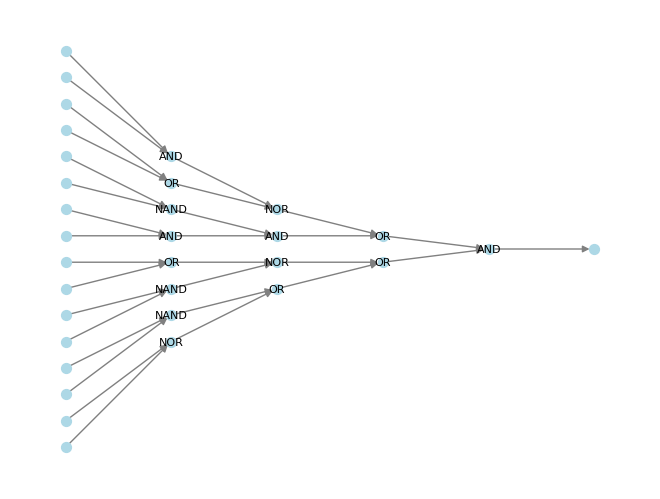

In [307]:
depth = 4
fg = binary_tree_function_graph(depth, 2, random_boolean_gate)

visualize_boolean_circuit(fg)

In [308]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 2**depth
output_size = 1

# Generate training data
num_samples = 100000
coordinates = (np.random.randint(0, 2, (num_samples, input_size)) * 2) - 1.

# Calculate the output values for the training data
output_values = ((fg.evaluate((coordinates + 1) // 2)) * 2) - 1.

# Split the data into training and validation sets
train_split = int(0.8 * num_samples)
train_x = torch.tensor(coordinates[:train_split], dtype=torch.float32, device=device)
train_y = torch.tensor(output_values[:train_split], dtype=torch.float32, device=device)
val_x = torch.tensor(coordinates[train_split:], dtype=torch.float32, device=device)
val_y = torch.tensor(output_values[train_split:], dtype=torch.float32, device=device)

batch_size = 512
batches = (len(train_x) // batch_size)
train_x_batched = train_x[:(batches*batch_size)].reshape(batches, batch_size, -1)
train_y_batched = train_y[:(batches*batch_size)].reshape(batches, batch_size, -1)
fg.evaluate((coordinates + 1) // 2).sum()

27937

In [309]:
model = nn.Sequential(
    nn.Linear(input_size, 2*input_size),
    nn.ReLU(),
    nn.Linear(2*input_size, 2*input_size),
    nn.ReLU(),
    nn.Linear(2*input_size, 2*input_size),
    nn.ReLU(),
    nn.Linear(2*input_size, 1),
)

In [310]:
loss_function = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for train_x, train_y in zip(train_x_batched, train_y_batched):
        optimizer.zero_grad(set_to_none=True)
        outputs = model(train_x)
        loss = loss_function(outputs, train_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= train_x_batched.size(0)

    model.eval()
    with torch.no_grad():
        outputs = model(val_x)
        loss = loss_function(outputs, val_y)
        val_loss = loss.item()

    if (epoch % (num_epochs // 10)) == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}")


Epoch: 1/100, Train Loss: 0.481464, Validation Loss: 0.169599
Epoch: 11/100, Train Loss: 0.003087, Validation Loss: 0.002392
Epoch: 21/100, Train Loss: 0.000029, Validation Loss: 0.000057
Epoch: 31/100, Train Loss: 0.000012, Validation Loss: 0.000034
Epoch: 41/100, Train Loss: 0.000008, Validation Loss: 0.000020
Epoch: 51/100, Train Loss: 0.000004, Validation Loss: 0.000014
Epoch: 61/100, Train Loss: 0.000008, Validation Loss: 0.000040
Epoch: 71/100, Train Loss: 0.000003, Validation Loss: 0.000005
Epoch: 81/100, Train Loss: 0.000002, Validation Loss: 0.000007
Epoch: 91/100, Train Loss: 0.000157, Validation Loss: 0.000084


In [322]:
test = torch.randint(0, 2, (input_size,), dtype=torch.float32)
#test = torch.tensor([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.])
#test = torch.zeros(input_size)
expected = (fg.evaluate(test) * 2) - 1.
actual = model((test * 2) - 1)
(test, expected, actual)

(tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.]),
 array([[1.]]),
 tensor([1.0004], grad_fn=<AddBackward0>))

# Editing

In [324]:
original_model = copy.deepcopy(model)
original_fg = copy.deepcopy(fg)

69598

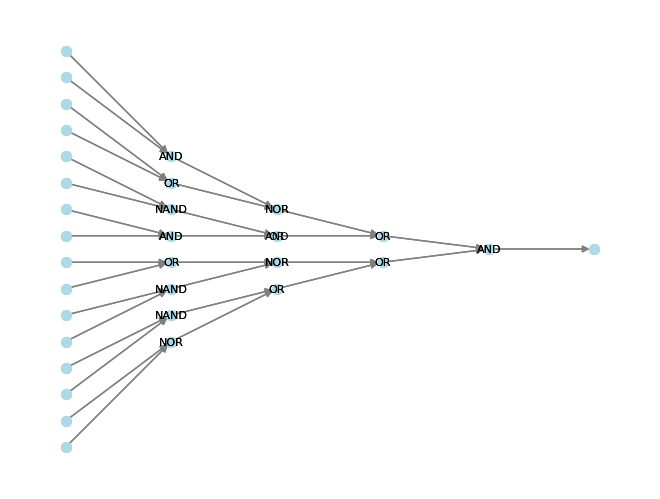

In [326]:
new_func = BooleanFunction(2, GATES_BY_NAME["OR"])
fg.graph.nodes["level_1_node_1"]["obj"] = new_func
fg.graph.nodes["level_1_node_1"]["function"] = new_func.evaluate

visualize_boolean_circuit(fg)

fg.evaluate((coordinates + 1) // 2).sum()

In [333]:
test = torch.randint(0, 2, (input_size,), dtype=torch.float32)
original_output = original_fg.evaluate(test)
new_output = fg.evaluate(test)
(test, original_output, new_output)

(tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.]),
 array([[0]], dtype=uint8),
 array([[1]], dtype=uint8))

# Continuing training

In [338]:
# Calculate the output values for the training data
output_values = ((fg.evaluate((coordinates + 1) // 2)) * 2) - 1.

# Split the data into training and validation sets
train_split = int(0.8 * num_samples)
train_x = torch.tensor(coordinates[:train_split], dtype=torch.float32, device=device)
train_y = torch.tensor(output_values[:train_split], dtype=torch.float32, device=device)
val_x = torch.tensor(coordinates[train_split:], dtype=torch.float32, device=device)
val_y = torch.tensor(output_values[train_split:], dtype=torch.float32, device=device)

batch_size = 512
batches = (len(train_x) // batch_size)
train_x_batched = train_x[:(batches*batch_size)].reshape(batches, batch_size, -1)
train_y_batched = train_y[:(batches*batch_size)].reshape(batches, batch_size, -1)
fg.evaluate((coordinates + 1) // 2).sum()

69598

In [437]:
#model = copy.deepcopy(original_model)
#model = nn.Sequential(
#    nn.Linear(input_size, 2*input_size),
#    nn.ReLU(),
#    nn.Linear(2*input_size, 2*input_size),
#    nn.ReLU(),
#    nn.Linear(2*input_size, 2*input_size),
#    nn.ReLU(),
#    nn.Linear(2*input_size, 1),
#)


In [438]:
def model_difference(model1, model2):
    diff_sum = torch.tensor(0.0)
    count = torch.tensor(0)

    for (param1, param2) in zip(model1.parameters(), model2.parameters()):
        diff = param1 - param2
        diff_sum += diff.abs().sum()
        count += torch.numel(diff)

    mean_diff = diff_sum / count
    return mean_diff

loss_function = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 400

for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for train_x, train_y in zip(train_x_batched, train_y_batched):
        optimizer.zero_grad(set_to_none=True)
        outputs = model(train_x)
        loss = loss_function(outputs, train_y)
        loss += 0.1 * model_difference(model, original_model)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= train_x_batched.size(0)

    model.eval()
    with torch.no_grad():
        outputs = model(val_x)
        loss = loss_function(outputs, val_y)
        val_loss = loss.item()

    if (epoch % (num_epochs // 10)) == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}, Model Difference: {model_difference(model, original_model):.6f}")


Epoch: 1/400, Train Loss: 0.558245, Validation Loss: 0.186695, Model Difference: 0.162172
Epoch: 41/400, Train Loss: 0.005329, Validation Loss: 0.000128, Model Difference: 0.051338
Epoch: 81/400, Train Loss: 0.002943, Validation Loss: 0.000098, Model Difference: 0.028335
Epoch: 121/400, Train Loss: 0.002618, Validation Loss: 0.000108, Model Difference: 0.025340
Epoch: 161/400, Train Loss: 0.002218, Validation Loss: 0.000068, Model Difference: 0.021627
Epoch: 201/400, Train Loss: 0.001884, Validation Loss: 0.000094, Model Difference: 0.018258
Epoch: 241/400, Train Loss: 0.001789, Validation Loss: 0.000072, Model Difference: 0.017311
Epoch: 281/400, Train Loss: 0.001776, Validation Loss: 0.000056, Model Difference: 0.017026
Epoch: 321/400, Train Loss: 0.001657, Validation Loss: 0.000058, Model Difference: 0.016021
Epoch: 361/400, Train Loss: 0.001683, Validation Loss: 0.000053, Model Difference: 0.016007


In [429]:
test = test = torch.randint(0, 2, (input_size,), dtype=torch.float32)
expected_original = (original_fg.evaluate(test) * 2) - 1.
actual_original = original_model((test * 2) - 1)
expected = (fg.evaluate(test) * 2) - 1.
actual = model((test * 2) - 1)
(test, expected_original, actual_original, expected, actual)

(tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.]),
 array([[-1.]]),
 tensor([-0.9981], grad_fn=<AddBackward0>),
 array([[1.]]),
 tensor([0.9986], grad_fn=<AddBackward0>))

In [440]:
diffs = []
for (param1, param2) in zip(original_model.parameters(), model.parameters()):
    diffs.append(param1.detach() - param2.detach())

px.histogram(diffs[2].flatten())

#(torch.nonzero(diffs[2].abs() > 0.02), torch.nonzero(diffs_old[2].abs() > 0.02))